In [45]:
import pandas as pd
import openpyxl
import os
import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from category_encoders import HashingEncoder


In [46]:
file_path = Path("intermediate_tables") / "parquet_files" / "df_processed_weather_crop_sentinel2_soil.parquet"
file_path = file_path.resolve()

df_full_dataset = pd.read_parquet(file_path, engine='pyarrow')


df_full_dataset.drop(columns=[ 'Soil_Year', 'Name', 'State', 'RegionName', 'SiteDescription', 'SowingDate', 'HarvestDate', 'Abandoned', 'Soil_TrialCode', 'TrialCode','CultivarID'], inplace=True)



df_full_dataset.head()

df_full_dataset.columns

Index(['Year', 'GrainYield_gm2', 'T.Max_avg', 'T.Min_avg', 'Rain_avg',
       'Evap_avg', 'Radn_avg', 'VP_avg', 'RHmaxT_avg', 'RHminT_avg', 'ndvi',
       'evi', 'evi2', 'gndvi', 'avi', 'savi', 'osavi', 'vari', 'ndmi', 'msi',
       'sipi', 'ndre1', 'ndre2', 'dvi', 'cirededge', 'ccci', 'Soil_SoilTestID',
       'Soil_MinDepth', 'Soil_MaxDepth', 'Soil_Ammonium Nitrogen',
       'Soil_Conductivity (EC)', 'Soil_Exchangeable Al',
       'Soil_Exchangeable Ca', 'Soil_Exchangeable K', 'Soil_Exchangeable Mg',
       'Soil_Exchangeable Na', 'Soil_Nitrate Nitrogen', 'Soil_Organic Carbon',
       'Soil_pH (CaCl2)', 'Soil_pH (water)', 'Soil_Phosphorous',
       'Soil_Sulphur', 'Soil_Texture'],
      dtype='object')

In [47]:
X = df_full_dataset.drop(columns=['GrainYield_gm2'])
y = df_full_dataset['GrainYield_gm2']

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
import category_encoders as ce
# Create a target encoder
# target_encoder = ce.TargetEncoder(cols=['CultivarID'])
# target_encoder2 = ce.TargetEncoder(cols=['TrialCode'])

categorical_cols = ["CultivarID", "TrialCode"]
encoder = ce.TargetEncoder(cols=categorical_cols)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)



In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  
    'max_depth': [None, 1, 3, 5, 7,8],       
    'learning_rate': [0.01, 0.1, 0.3,0.4,0.6,0.8], 
    'subsample': [0.6, 0.8, 1.0],    
    'colsample_bytree': [0.6, 0.8, 1.0]  
}

# param_grid = {
#     'n_estimators': [500],  # Number of trees
#     'max_depth': [8],          # Maximum depth of trees
#     'learning_rate': [0.1],  # Step size shrinkage
#     'subsample': [1.0],    # Fraction of samples used per tree
#     'colsample_bytree': [0.6]  # Fraction of features used per tree
# }

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimize for MSE
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE (negative):", grid_search.best_score_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 1.0}
Best MSE (negative): -1386.8532777158284


In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Initialize XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    objective='reg:squarederror',  # important for regression tasks
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)


print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')
print(f'Train MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Train R2: {r2_train}')
print(f'Test R2: {r2_test}')

Train MSE: 1772.220823485772
Test MSE: 1794.6841436287646
Train MAE: 31.101642695516542
Test MAE: 31.288880893766375
Train R2: 0.9390521177553296
Test R2: 0.9382986027669419


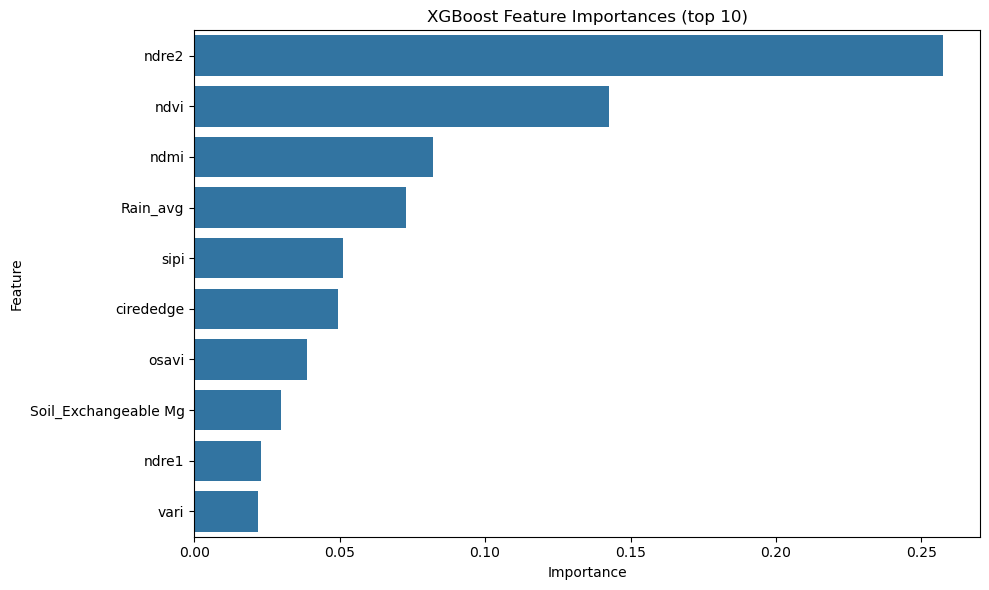

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances
importances = model.feature_importances_
features = X_train.columns  # if using DataFrame
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

#top 10 features
feat_imp_df = feat_imp_df.head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('XGBoost Feature Importances (top 10)')
plt.tight_layout()
plt.show()

In [45]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error']
}

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')

Best Parameters: {'criterion': 'absolute_error', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: -1628.1353486923967


In [49]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Re-initialize the model with best parameters
rf_best = RandomForestRegressor(
    criterion='absolute_error',
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=300,
    random_state=42
)

# Fit the model
rf_best.fit(X_train, y_train)

# rf_best predictions
y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)
# Calculate RMSE and R2 for train and test sets
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train RMSE: {mse_train}')
print(f'Test RMSE: {mse_test}')
print(f'Train MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Train R2: {r2_train}')
print(f'Test R2: {r2_test}')

Train RMSE: 1792.9745976231764
Test RMSE: 1823.112448238204
Train MAE: 30.916978783756033
Test MAE: 31.334727761905047
Train R2: 0.9383383813148723
Test R2: 0.9373212351774435


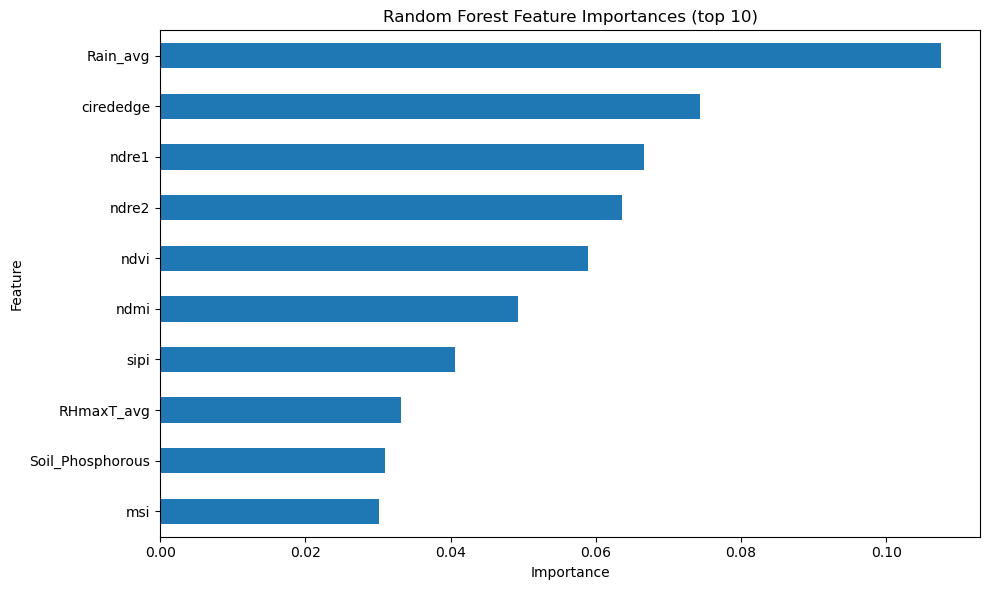

In [51]:
importances = rf_best.feature_importances_

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Optional: Plot top features
feature_importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6), legend=False)
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (top 10)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [34]:
# load data
file_path = Path("intermediate_tables") / "parquet_files" / "processed_weather_and_crop_data.parquet"
file_path = file_path.resolve()

df_centralised = pd.read_parquet(file_path, engine='pyarrow')

import category_encoders as ce
# Create a target encoder
target_encoder = ce.TargetEncoder(cols=['CultivarID'])

# Fit and transform the 'CultivarID' column using the target encoder
df_centralised['CultivarID_encoded'] = target_encoder.fit_transform(df_centralised['CultivarID'], df_centralised['GrainYield_gm2'])

df_centralised.head()

df_centralised.columns

Index(['Year', 'Name', 'State', 'RegionName', 'SiteDescription', 'TrialCode',
       'SowingDate', 'HarvestDate', 'Abandoned', 'CultivarID',
       'GrainYield_gm2', 'T.Max_avg', 'T.Min_avg', 'Rain_avg', 'Evap_avg',
       'Radn_avg', 'VP_avg', 'RHmaxT_avg', 'RHminT_avg', 'CultivarID_encoded'],
      dtype='object')

In [35]:
X_cols = ['Year', 'T.Max_avg', 'T.Min_avg', 'Rain_avg', 'Evap_avg',
       'Radn_avg', 'VP_avg', 'RHmaxT_avg', 'RHminT_avg', 'CultivarID_encoded']

X = df_centralised[X_cols]
y = df_centralised['GrainYield_gm2']

y.head()

0    422.902494
1    342.403628
2    408.491107
3    392.290249
4    349.579832
Name: GrainYield_gm2, dtype: float64

## Random Forest

### Train Test split

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# random forest regression

#gridsearch for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error']
}

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')
#Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#Best Score: -14.458315037066777

Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: -14.458315037066777


In [37]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Re-initialize the model with best parameters
rf_best = RandomForestRegressor(
    criterion='squared_error',
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

# Fit the model
rf_best.fit(X_train, y_train)

# rf_best predictions
y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)
# Calculate RMSE and R2 for train and test sets
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train MSE: {rmse_train}')
print(f'Test MSE: {rmse_test}')
print(f'Train MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Train R2: {r2_train}')
print(f'Test R2: {r2_test}')



Train MSE: 719.448364235566
Test MSE: 1949.1606555650674
Train MAE: 19.107294216452214
Test MAE: 31.540533962477145
Train R2: 0.9762814558166403
Test R2: 0.9361194486266609


              Feature  Importance
3            Rain_avg    0.256206
7          RHmaxT_avg    0.138778
8          RHminT_avg    0.108566
4            Evap_avg    0.108217
6              VP_avg    0.090828
1           T.Max_avg    0.081754
2           T.Min_avg    0.067030
9  CultivarID_encoded    0.060853
5            Radn_avg    0.057985
0                Year    0.029784


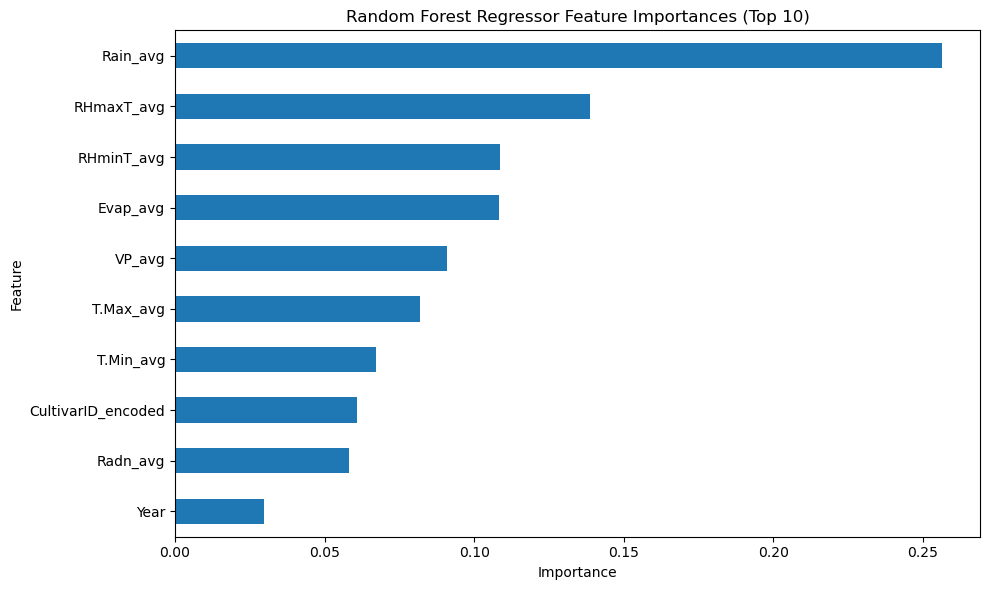

In [38]:
importances = rf_best.feature_importances_

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print top 10 features
print(feature_importance_df.head(10))

# Optional: Plot top features
feature_importance_df.head(15).plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6), legend=False)
plt.gca().invert_yaxis()
plt.title('Random Forest Regressor Feature Importances (Top 10)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## XGboost


In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
#     'max_depth': [None, 1, 3, 5, 7,8],          # Maximum depth of trees
#     'learning_rate': [0.01, 0.1, 0.3,0.4,0.6,0.8],  # Step size shrinkage
#     'subsample': [0.6, 0.8, 1.0],    # Fraction of samples used per tree
#     'colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features used per tree
# }

param_grid = {
    'n_estimators': [500],  # Number of trees
    'max_depth': [8],          # Maximum depth of trees
    'learning_rate': [0.1],  # Step size shrinkage
    'subsample': [1.0],    # Fraction of samples used per tree
    'colsample_bytree': [0.6]  # Fraction of features used per tree
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimize for MSE
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all CPU cores
)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE (negative):", grid_search.best_score_)
#Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
#Best MSE (negative): -1717.9864463093713

#Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 1.0}
#Best MSE (negative): -1683.7088557772302

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 1.0}
Best MSE (negative): -1683.7088557772302


In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing


# Initialize XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.6,
    objective='reg:squarederror',  # important for regression tasks
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Evaluate
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)


print(f'Train MSE: {rmse_train}')
print(f'Test MSE: {rmse_test}')
print(f'Train MAE: {mae_train}')
print(f'Test MAE: {mae_test}')
print(f'Train R2: {r2_train}')
print(f'Test R2: {r2_test}')

Train MSE: 1186.7143036882364
Test MSE: 1659.2543146009702
Train MAE: 25.1962280057537
Test MAE: 29.405897559429338
Train R2: 0.9608767813726818
Test R2: 0.9456206546224514


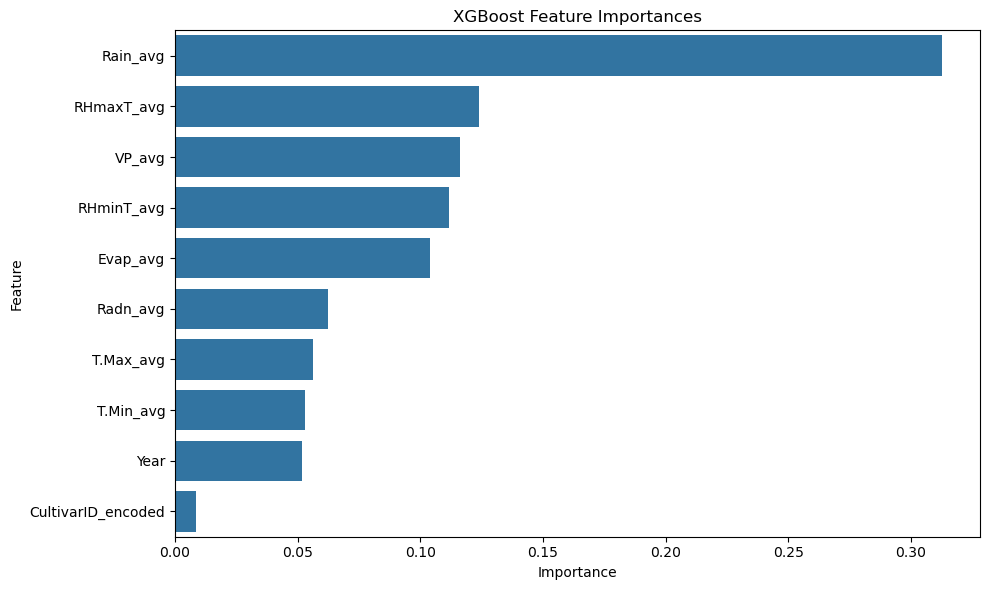

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importances
importances = model.feature_importances_
features = X_train.columns  # if using DataFrame
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()